## Generate inputs for Cell2Fire
- LCP to GeoTIFF
- GeoTIFF to ASCII
- Ignition point to CSV
- Weather data to CSV

In [3]:
import os, glob, shutil
import tqdm
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import seaborn as sns
import geopandas as gpd
from pathlib import Path
from typing import List, Union, Optional
from random import randint, choice
from datetime import datetime, timedelta

import shapely
from shapely.geometry import box, Point, MultiPoint
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.io import MemoryFile


In [4]:
# Basic parameters and paths
data_path = '/Users/minho/Documents/GitHub/Cell2Fire/data/real'

if not os.path.exists(data_path):
    os.mkdir(data_path)

CRS_LATLON = 4326
CRS_UTM = 32610

In [5]:
# Basic parameters and paths
# shp1_path = os.path.join(data_path, 'aoi.shp')                             # AOI
shp1_path= None
# ig_path = os.path.join(data_path, 'ig_pt_real.shp')                            # Ignition point   

In [6]:
from datetime import datetime, timedelta

def create_wxs_file(weather_df=None, file_name=None, start_date=None, end_date=None, timezone='UTC'):

    if len(weather_df)>0:
        weather_data = weather_df
        weather_data['Date'] = pd.to_datetime(weather_data['Date'], format='%m/%d/%y %H:%M')

        # Extract year, month, day, and time
        weather_data['Year'] = weather_data['Date'].dt.year
        weather_data['Mth'] = weather_data['Date'].dt.month
        weather_data['Day'] = weather_data['Date'].dt.day
        weather_data['Time'] = weather_data['Date'].dt.strftime('%H%M')

    else:
        # Define the date range
        date_range = pd.date_range(start=start_date, end=end_date, freq='D')

        # Create a DataFrame to hold the weather data
        weather_data = pd.DataFrame({
            'Date': date_range.strftime('%Y%m%d'),
            'Time': ['1200'] * len(date_range),  # Time set to noon for simplicity
            'Temp': np.random.randint(60, 100, size=len(date_range)),  # Random temperatures
            'HrlyPcp': np.random.randint(10, 50, size=len(date_range)),      # Random relative humidity
            'Rain': np.random.uniform(0, 0.5, size=len(date_range)),    # Random rain in inches
            'WindSpd': np.random.uniform(0, 20, size=len(date_range)),  # Random wind speed in mph
            'WindDir': np.random.randint(0, 360, size=len(date_range)), # Random wind direction in degrees
            'CloudCov': np.random.randint(0, 100, size=len(date_range)) # Random cloud cover percentage
        })

    # Format the data to align directly under the headers using tabs
    weather_data['Weather'] = weather_data.apply(
        lambda row: f"{row['Year']}\t{row['Month']}\t{row['Day']}\t{row['Time']}\t{row['Temp']}\t{row['RH']}\t{row['HrlyPcp']:.2f}\t{row['WindSpd']}\t{row['WindDir']}\t{row['CloudCov']}",
        axis=1
    )

    # Write to a .wxs file with the correct header and formatting
    with open(file_name, 'w') as file:
        file.write('RAWS_UNITS: English\n')
        file.write('RAWS_ELEVATION: 0\n')
        file.write('RAWS: 2\n')
        file.write('Year\tMth\tDay\tTime\tTemp\tRH\tHrlyPcp\tWindSpd\tWindDir\tCloudCov\n')
        for weather in weather_data['Weather']:
            file.write(weather + '\n')


In [7]:
# Parameters
file_name = os.path.join(data_path, '2019_bobcat', 'weather_data.wxs')  # Specify the desired output file path

df = pd.read_csv(os.path.join(data_path, '2019_bobcat', 'all_weather.csv'))

# Create the .wxs file
create_wxs_file(weather_df=df, file_name=file_name)
print(f"Weather file '{file_name}' created successfully!")

KeyError: 'Month'

#### 0. Find the LCP region
Use spatial indexing to find overlap and call input datasets (LCP)

In [9]:
# Set ignition point
all_fires = gpd.read_file(os.path.join(data_path, 'fire23_1.gdb'), layer=0)

ig_pt = gpd.GeoDataFrame(geometry=[Point(1.846975, 41.623128)]).set_crs(4326).to_crs(25831)
buffer_distance = 8000

# Create a bbox around the point with the specified distance
minx, miny = ig_pt.geometry.x - buffer_distance, ig_pt.geometry.y - buffer_distance
maxx, maxy = ig_pt.geometry.x + buffer_distance, ig_pt.geometry.y + buffer_distance

aoi = gpd.GeoDataFrame(geometry=[box(minx, miny, maxx, maxy)]).set_crs(25831)

/Users/minho/Desktop/Projects/suppression_networks/barcelona_work/paper/firepolygons/lib/python3.10/site-packages/pyogrio/raw.py:196: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(
/Users/minho/Desktop/Projects/suppression_networks/barcelona_work/paper/firepolygons/lib/python3.10/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


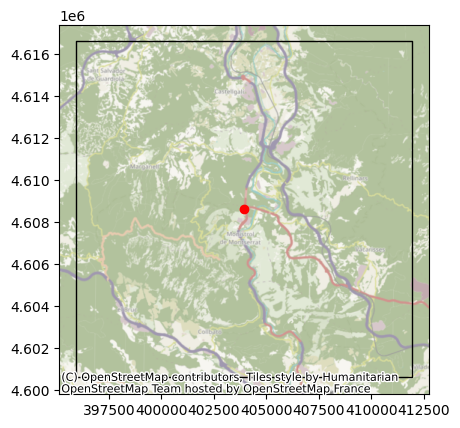

In [11]:
import contextily as ctx

fig, ax = plt.subplots(1)

ig_pt.plot(ax=ax, color='r')
aoi.plot(ax=ax, color='none', edgecolor='k')
ctx.add_basemap(ax=ax, crs=25831)

In [12]:
# Load all LCPs shapefile
gdf = gpd.read_file(os.path.join(all_lcp_path, 'all_bnds.shp'))

# Define the AOI as a bounding box (xmin, ymin, xmax, ymax)
shp1 = gpd.read_file(shp1_path).set_crs(CRS_LATLON).to_crs(CRS_UTM) if shp1_path else None 

if shp1 is not None:
    print("Point ignition given")
    aoi_polygon = shp1
# elif shp1_path:
#     print("AOI created from POI and buffer")
#     aoi_polygon = gpd.GeoDataFrame(geometry=[box(*shp1.total_bounds)]).set_crs(CRS_LATLON).to_crs(CRS_UTM)
else:
    aoi_polygon = aoi

# Find the intersecting polygons using spatial indexing
intersecting_gdf = gpd.overlay(aoi_polygon, gdf)

# Extract the indices of the intersecting polygons
intersecting_idx = intersecting_gdf['idx'].tolist()

# Generate the filenames for the corresponding .lcp files
intersecting_lcp_filenames = [os.path.join(all_lcp_path, f'ZHR_{index}.lcp') for index in intersecting_idx]
print(sorted(intersecting_lcp_filenames))

# Function to clip a raster using a polygon
def clip_raster(lcp_filepath, polygon):
    with rasterio.open(lcp_filepath) as src:
        out_image, out_transform = mask(src, [polygon], crop=True)
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
        return out_image, out_meta

# List to hold the clipped rasters in MemoryFile
clipped_rasters = []
for idx, lcp_file in zip(intersecting_idx, intersecting_lcp_filenames):
    polygon = intersecting_gdf[intersecting_gdf['idx'] == idx].geometry.values[0]
    clipped_image, clipped_meta = clip_raster(lcp_file, polygon)
    memfile = MemoryFile()
    with memfile.open(**clipped_meta) as dataset:
        dataset.write(clipped_image)
    clipped_rasters.append(memfile)

# Merge the clipped rasters
with rasterio.open(clipped_rasters[0]) as src0:
    out_meta = src0.meta.copy()

merged_image, merged_transform = merge([r.open() for r in clipped_rasters], method='first')

# Update metadata for the merged raster
out_meta.update({"driver": "GTiff",
                 "height": merged_image.shape[1],
                 "width": merged_image.shape[2],
                 "transform": merged_transform,
                 "crs": src0.crs,
                 "count": merged_image.shape[0]  # Ensure the correct number of bands
})

# Define the output path for the merged raster
output_lcp_path = os.path.join(data_path, 'lcp.tif')

# Write the merged raster to disk
with rasterio.open(output_lcp_path, "w", **out_meta) as dest:
    dest.write(merged_image)

print(f'Merged raster saved to {output_lcp_path}')

NameError: name 'all_lcp_path' is not defined

#### 1. LCP to GeoTIFF

In [ ]:
# Nodata value
nodata_value = -9999

# LCP variables
band_variable_names = {
    1: 'elevation',
    2: 'slope',
    3: 'aspect',
    4: 'fuels',
    5: 'cc',
    6: 'ch',
    7: 'cbh',
    8: 'cbd'
}
# Load data
with rasterio.open(output_lcp_path, 'r') as src:

    # Read all bands and assign variable names
    bands_data = {}
    meta = src.meta.copy()
    for band_num, variable_name in band_variable_names.items():
        band_data = src.read(band_num).astype(float)

        # Set nodata values
        if src.nodata is not None:
            band_data[band_data == src.nodata] = np.nan
        else:
            band_data[band_data == nodata_value] = np.nan

        bands_data[variable_name] = band_data

        # Update metadata with the specific band's information
        meta.update(driver='GTiff', count=1, dtype='uint8', crs=CRS_UTM)

        # Set output path
        output_path = os.path.join(data_path, str(variable_name) + '.tif')

        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(bands_data[variable_name].astype('uint8'), 1)

/tmp/ipykernel_3052137/3166125355.py:39: RuntimeWarning: invalid value encountered in cast
  dst.write(bands_data[variable_name].astype('uint8'), 1)


In [ ]:
with rasterio.open(output_lcp_path, 'r') as src:
    meta = src.meta
meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 801,
 'height': 801,
 'count': 8,
 'crs': None,
 'transform': Affine(20.0, 0.0, 395932.38261041,
        0.0, -20.0, 4616595.6527613)}

#### 1-2 GeoTIFF to ASCII

In [ ]:
def geotiff_to_ascii(inpath):

    # Set output ASCII filename
    outpath = inpath.replace('tif', 'asc')

    # Load input GeoTIFF
    with rasterio.open(inpath, 'r') as src:
        data = src.read(1)
        meta = src.meta.copy()

    NODATA_value = meta['nodata']
    ncols = meta['width']
    nrows = meta['height']
    cellsize = meta['transform'][0]
    xllcorner = meta['transform'][2]
    yllcorner = meta['transform'][5]

    # Output ASCII
    with open(outpath, 'w') as f:
        f.write(f'ncols {ncols}\n')
        f.write(f'nrows {nrows}\n')
        f.write(f'xllcorner {xllcorner}\n')
        f.write(f'yllcorner {yllcorner}\n')
        f.write(f'cellsize {cellsize}\n')
        f.write(f'NODATA_value {NODATA_value}\n')
        np.savetxt(f, data, fmt='%d')

In [13]:
# 1. Convert GeoTIFF to ASCII
filelist = glob.glob(os.path.join(data_path, '*.tif'))

for fpath in tqdm.tqdm(filelist, total=len(filelist), desc='Converting...'):
    geotiff_to_ascii(fpath)

Converting...: 0it [00:00, ?it/s]


## 2. Ignition point

#### 2-1. Random ignition point(s)

In [91]:
# # Create random ignition point samples on fuel map
# def find_random_coordinates(image_array, no_data_value, num_samples=1000):

#     rows, cols = image_array.shape

#     # Flatten the array to easily sample random indices
#     flat_indices = np.arange(rows * cols)
#     valid_indices = np.where(image_array.flatten() != no_data_value)[0]

#     # Randomly sample from the valid indices
#     random_indices = np.random.choice(valid_indices, size=num_samples, replace=False)
#     sampled_coordinates = np.unravel_index(random_indices, (rows, cols))
#     sampled_indices = np.ravel_multi_index(sampled_coordinates, image_array.shape)

#     return sampled_coordinates, sampled_indices

# # Find random coordinates in non-NaN fuel map
# sampled_coordinates, sampled_indices = find_random_coordinates(bands_data['fuel'], no_data_value=99.0)

# # Create CSV file
# ignition_points = pd.DataFrame({'Year':[], 'NCell':[]})
# ignition_points['NCell'] = sampled_indices
# ignition_points['Year'] = ignition_points.index.to_list()

#### 2-2. Defined ignition point

In [92]:
from shapely.geometry import Point

# Set coordinates
# xy = Point(1.901456, 41.685603)
xy = ig_pt
## Save (if needed)
ig_pt.to_file(os.path.join(data_path, 'ig_pt.shp'))

### Option 2
# xy=gpd.read_file(ig_path).geometry[0] # Ignition point (defined above)
# # Convert MultiPoint to Point (If erronously set) as first geom object
# if type(xy) == MultiPoint:
#     xy = Point(xy.geoms[0])
# ig_pt = gpd.GeoDataFrame(geometry=[xy]).set_crs(CRS_LATLON).to_crs(CRS_UTM)

In [93]:
from rasterio.mask import mask
from shapely.geometry import mapping

def crop_raster_with_shp(rasterfile_path, output_cropped_path=None, aoi=None, save=False):

    # Open the raster file
    with rasterio.open(rasterfile_path) as src:
        # Crop the raster using the shapefile's geometry
        out_image, out_transform = mask(src, aoi.geometry.apply(mapping), crop=True)

        # Update the metadata to reflect the changes
        out_meta = src.meta.copy()
        out_meta.update({
            'driver': 'GTiff',
            'height': out_image.shape[1],
            'width': out_image.shape[2],
            'transform': out_transform
        })

        if save:
            # Write the cropped raster to a new file
            with rasterio.open(output_cropped_path, 'w', **out_meta) as dest:
                dest.write(out_image)

            print("Cropped raster saved to:", output_cropped_path)


def get_point_on_raster(x, y, raster_path):

    # Open the raster file
    with rasterio.open(raster_path) as dataset:
        # Transform the point to the raster's coordinate system
        transform = dataset.transform
        # Get the row and column indices
        row, col = ~transform * (y, x)

    # Print the row and column
    print(f"Row: {int(row)}, Column: {int(col)}")

    return row, col


# XY coordinate to index
def coord_to_idx(row, col, ncols):
    """
    Convert row and column coordinates to index in a 2D array.

    Parameters:
        row (int): Row coordinate.
        col (int): Column coordinate.
        ncols (int): Number of columns in the 2D array.

    Returns:
        int: Index corresponding to the given row and column coordinates.
    """    
    return row * ncols + col

def idx_to_coord(index, ncols):
    """
    Convert index to row and column coordinates in a 2D array.

    Parameters:
        index (int): Index value.
        ncols (int): Number of columns in the 2D array.

    Returns:
        tuple: Row and column coordinates corresponding to the given index.
    """
    row = index // ncols
    col = index % ncols
    return row, col

In [97]:
# Get row, column

# Load image metadata and POI
meta = rasterio.open(output_path).meta

# Extract POI's coordinate relative to the image's extents
with rasterio.open(output_path, 'r') as src:
    row,col = src.index(ig_pt.geometry.x[0], ig_pt.geometry.y[0])

print("Row: {} and Column: {}".format(row, col))
# Print index on image array
id = coord_to_idx(row=row, col=col, ncols=meta['width'])
print("Index: ", id)

Row: 400 and Column: 400
Index:  319999


In [98]:
print("Fuel type at ignition: ", bands_data['fuels'][row, col])

Fuel type at ignition:  145.0


In [99]:
# Create CSV file
ignition_points = pd.DataFrame({'Year':[], 'NCell':[]})
ignition_points['NCell'] = [id]
ignition_points['Year'] = [2024]

In [100]:
ignition_points.to_csv(os.path.join(data_path, 'Ignitions.csv'), index=None)

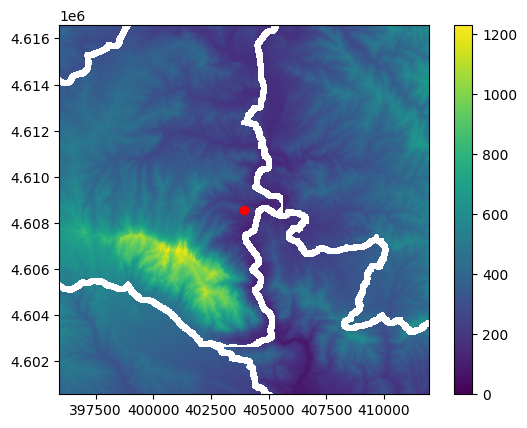

In [101]:
# Visualize
ex_src = rasterio.open(output_path)
bounds = ex_src.bounds
left, bottom, right, top = bounds.left, bounds.bottom, bounds.right, bounds.top


# Plot
fig, ax = plt.subplots(1)

im = ax.imshow(bands_data['elevation'], extent=(left, right, bottom, top))
fig.colorbar(im)

ig_pt.to_crs(CRS_UTM).plot(ax=ax, color='r')


# plt.savefig(os.path.join(results_path, 'ig_map.png'), bbox_inches='tight')
plt.show()

In [48]:
# # Find ignition point's value on the raster

# # Set raster path to load SRC (Rasterio read)
# raster_path = os.path.join(outpath, 'fuels.tif')

# # Find ignition point's row x column
# ig_pt_xy = crop_raster_with_shp(rasterfile_path=raster_path, aoi=ig_pt)

## 3. Weather

#### 3-1. Random weather

In [102]:
import random

# Random weather generator
def random_weather_scenario_generator(n_scenarios: int, 
                                     num_hr: Optional[int] = None,
                                     hr_limit: Optional[int] = None, 
                                     lambda_ws: Optional[float] = None,
                                     lambda_wd: Optional[float] = None, 
                                     output_folder: Optional[str] = None,
                                     scenario=None,
                                     ws_low = None,
                                     ws_high = None,
                                     wd_low = None,
                                     wd_high = None):

    hr_limit = hr_limit if hr_limit else 72
    lambda_ws = lambda_ws if lambda_ws else 0.5
    lambda_wd = lambda_wd if lambda_wd else 0.5
    output_folder = Path(output_folder) if output_folder else Path('Weathers')
    output_folder.mkdir(parents=True, exist_ok=True)  # Create the output directory if it doesn't exist

    for index, _ in enumerate(range(n_scenarios), start=1):
        if num_hr:
            n_rows = num_hr
        else:
            n_rows = randint(5, hr_limit) # Random duration with min of 5 hrs

        instance = ['Catalunya'] * n_rows
        fire_scenario = [scenario] * n_rows

        wd_0 = random.uniform(wd_low, wd_high)
        ws_0 = random.uniform(ws_low, ws_high) # Max wind speed set to 90 (*3.6 originally)

        wd_1 = abs(wd_0 + np.random.normal(loc=0.0, scale=10.0, size=None))
        ws_1 = abs(ws_0 + np.random.normal(loc=0.0, scale=5.0, size=None))

        ws = [ws_0, ws_1]
        wd = [wd_0, wd_1]

        dt = [(datetime.now() + timedelta(hours=i)).isoformat(timespec='minutes') for i in range(n_rows)]
        for row in range(2, n_rows):
            wd_i = wd[row - 1] * lambda_wd + wd[row - 2] * (1 - lambda_wd)
            ws_i = ws[row - 1] * lambda_wd + ws[row - 2] * (1 - lambda_wd)

            wd.append(wd_i)
            ws.append(ws_i)

        df = pd.DataFrame(np.vstack((instance, dt, ws, wd, fire_scenario)).T,
                          columns=['Instance', 'datetime', 'WS', 'WD', 'FireScenario'])
        
        # Change datetime format
        df['datetime'] = df['datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M").strftime("%m/%d/%y %H:%M"))

        output_path = output_folder / f'Weather{index}.csv'
        df.to_csv(output_path, index=False)

In [103]:
random_weather_scenario_generator(n_scenarios=10, num_hr=12, ws_low=25, ws_high=35, wd_low=270, wd_high=300, scenario=1,
                                  output_folder=os.path.join(data_path, 'Weathers'))

#### Copy LUT

In [104]:
# Original path
lut_path = os.path.join(data_path, '../catalunya_v1/spain_lookup_table.csv')

# Copy
shutil.copy(lut_path, os.path.join(data_path, 'spain_lookup_table.csv'))

'/home/minho/research/fire/networks/C2F-W/data/2024_Exercise4/spain_lookup_table.csv'

#### Merge inputs

In [54]:
# import numpy as np
# import rasterio
# from rasterio.merge import merge
# from rasterio.transform import from_bounds
# from rasterio.warp import calculate_default_transform, reproject, Resampling
# from rasterio.io import MemoryFile
# import os

# lcp_path1 = '/home/minho/research/fire/networks/main/data/ZHR_47.lcp'
# lcp_path2 = '/home/minho/research/fire/networks/main/data/ZHR_48.lcp'

# # Function to mask NaN values
# def mask_nans(data, nodata_value):
#     return np.ma.masked_equal(data, nodata_value)

# # Function to merge raster files while ignoring NaN values
# def merge_rasters(filepaths):
#     # Open the raster files
#     src_files_to_merge = [rasterio.open(filepath) for filepath in filepaths]

#     # Read bands and mask NaN values
#     bands_to_merge = []
#     for src in src_files_to_merge:
#         for band in range(1, src.count + 1):
#             data = src.read(band, masked=True)  # Read data with masking
#             nodata = src.nodata
#             if nodata is not None:
#                 data = mask_nans(data, nodata)  # Mask NaN values
#             bands_to_merge.append(data)

#     # Merge the datasets
#     merged, out_trans = merge(src_files_to_merge)

#     # Calculate the combined spatial extent
#     bounds = None
#     for src in src_files_to_merge:
#         bounds_tmp = src.bounds
#         if bounds is None:
#             bounds = bounds_tmp
#         else:
#             bounds = (
#                 min(bounds[0], bounds_tmp[0]),
#                 min(bounds[1], bounds_tmp[1]),
#                 max(bounds[2], bounds_tmp[2]),
#                 max(bounds[3], bounds_tmp[3])
#             )

#     # Calculate the profile for the merged raster
#     out_meta = src_files_to_merge[0].profile.copy()
#     out_meta.update({
#         'transform': from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], merged.shape[2], merged.shape[1]),
#         'width': merged.shape[2],
#         'height': merged.shape[1],
#         'count': merged.shape[0],  # number of bands in the merged dataset
#         'dtype': merged.dtype,
#         'crs': 25831  # assuming all input rasters have the same CRS
#     })

#     # Close the source files
#     for src in src_files_to_merge:
#         src.close()

#     return merged, out_meta

# # Example usage
# filepaths = [lcp_path1, lcp_path2]

# # Merge the rasters while ignoring NaN values
# merged_data, merged_profile = merge_rasters(filepaths)

# # Write the merged raster to a new file
# with rasterio.open('merged_raster.lcp', 'w', **merged_profile) as dst:
#     dst.write(merged_data)
